In [8]:
import numpy as np
import pandas as pd

np.random.seed(0)
import random

import tensorflow.keras as kearas
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense ,Dropout,Flatten
from tensorflow.keras.layers import Conv2D,MaxPool2D,BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='seaborn')

In [9]:
train = pd.read_csv("../datasets/digit-recognizer/train.csv")
test = pd.read_csv("../datasets/digit-recognizer/test.csv")

x_train = train.drop(labels=["label"],axis=1)
y_train = train['label']

x_test = test

print(x_train.shape,x_test.shape)

(42000, 784) (28000, 784)


- EDA

In [10]:
x_train_plot = x_train.values.reshape(-1,28,28) # reconstruct each flat row into its original 28×28 image shape

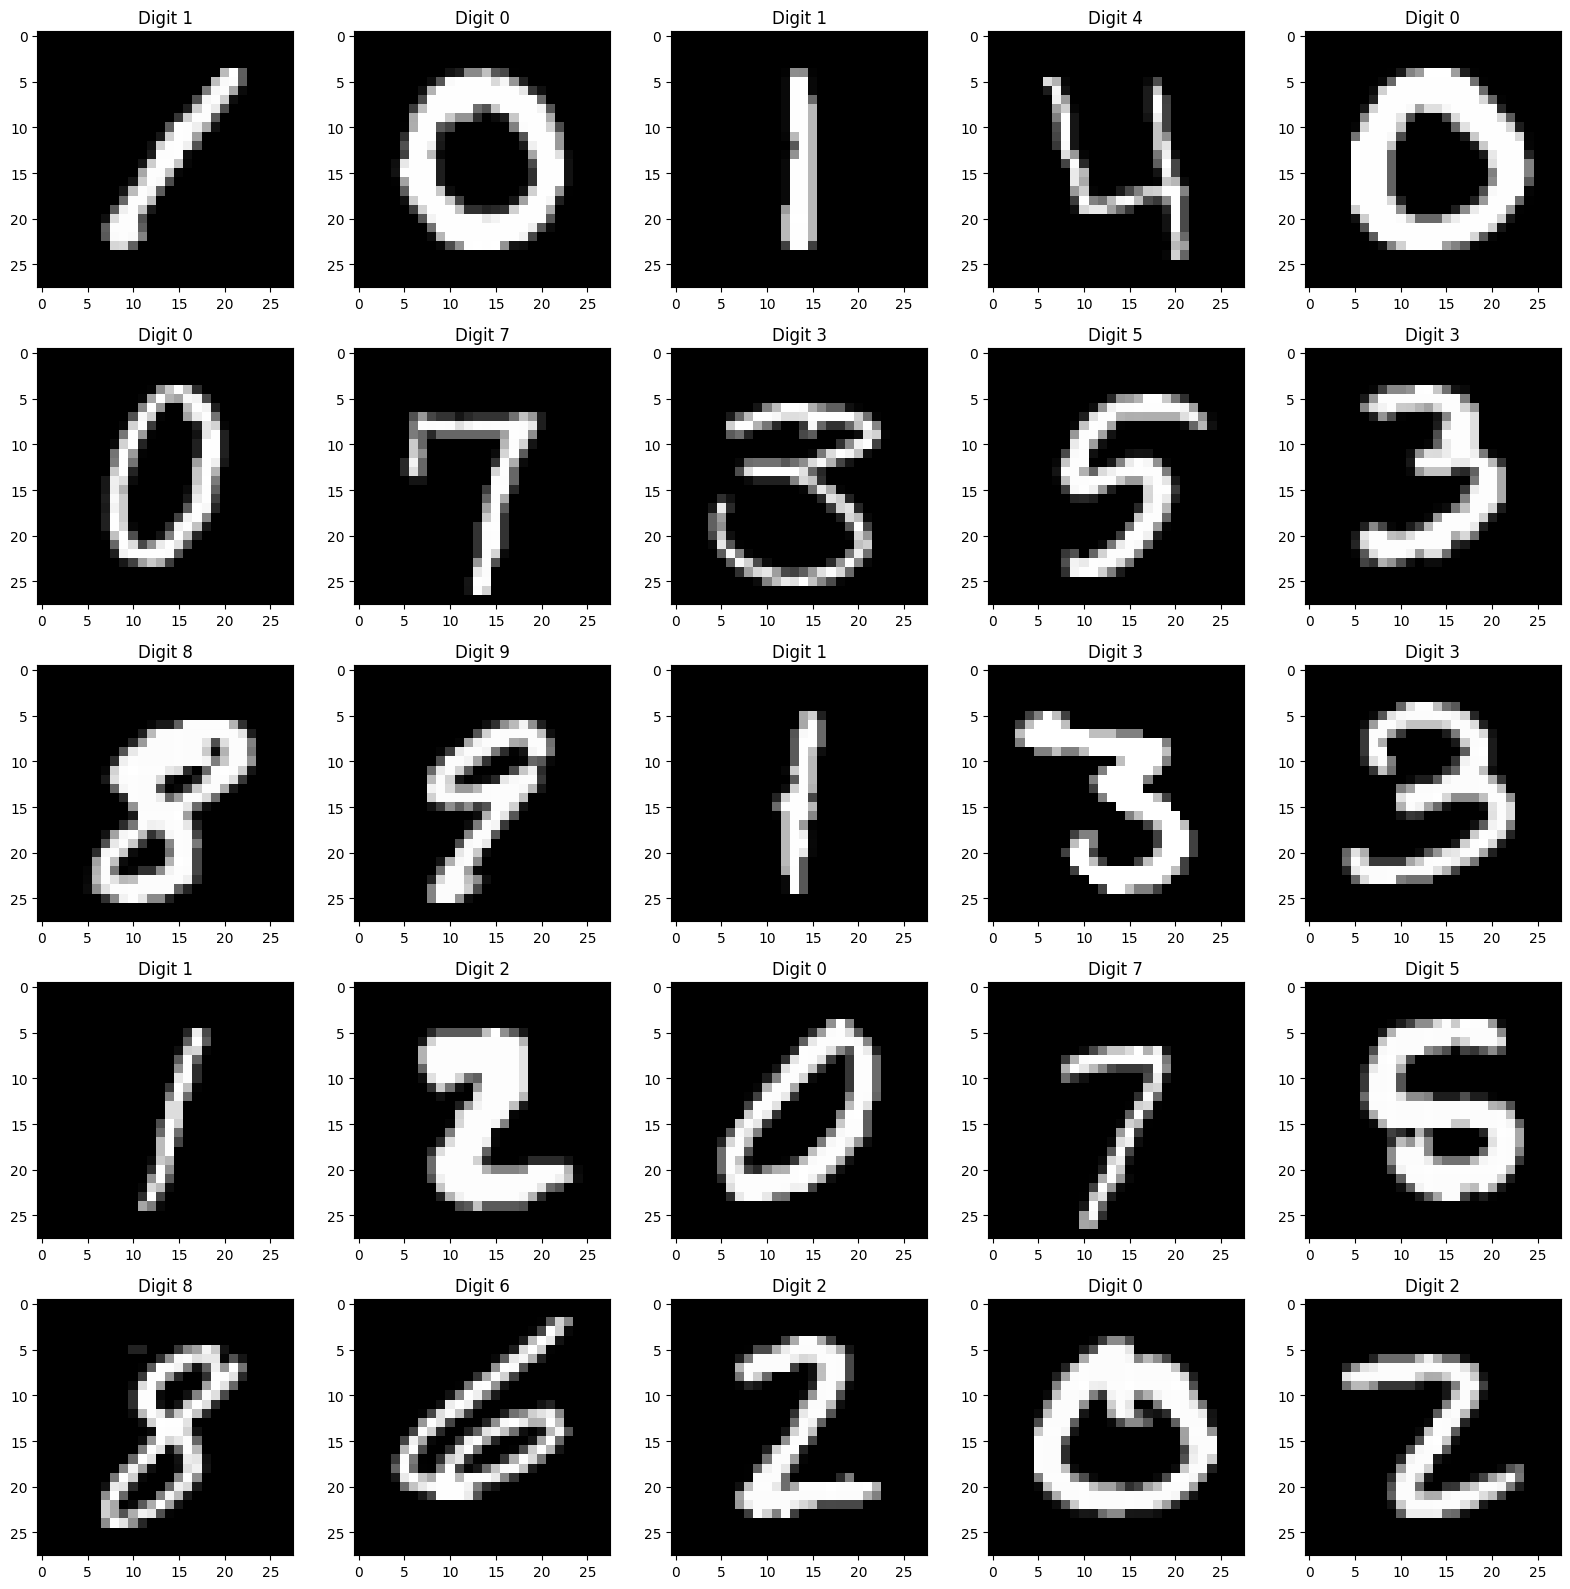

In [11]:
def Show_example_digits(mono="gray"):
    fit = plt.figure(figsize = (16,16))
    for idx in range(25):
        plt.subplot(5,5,idx+1)
        plt.imshow(x_train_plot[idx],cmap=mono)
        plt.title("Digit {}".format(y_train[idx]))

    plt.tight_layout()

Show_example_digits()

In [12]:
# Function return digit in grayscale
def plot_digit(digit, dem = 28, font_size = 12):
    max_ax = font_size * dem
    
    fig = plt.figure(figsize=(13, 13))
    plt.xlim([0, max_ax])
    plt.ylim([0, max_ax])
    plt.axis('off')
    black = '#000000'
    
    for idx in range(dem):
        for jdx in range(dem):

            t = plt.text(idx * font_size, max_ax - jdx*font_size, digit[jdx][idx], fontsize = font_size, color = black)
            c = digit[jdx][idx] / 255.
            t.set_bbox(dict(facecolor=(c, c, c), alpha = 0.5, edgecolor = 'black'))
            
    plt.show()

3


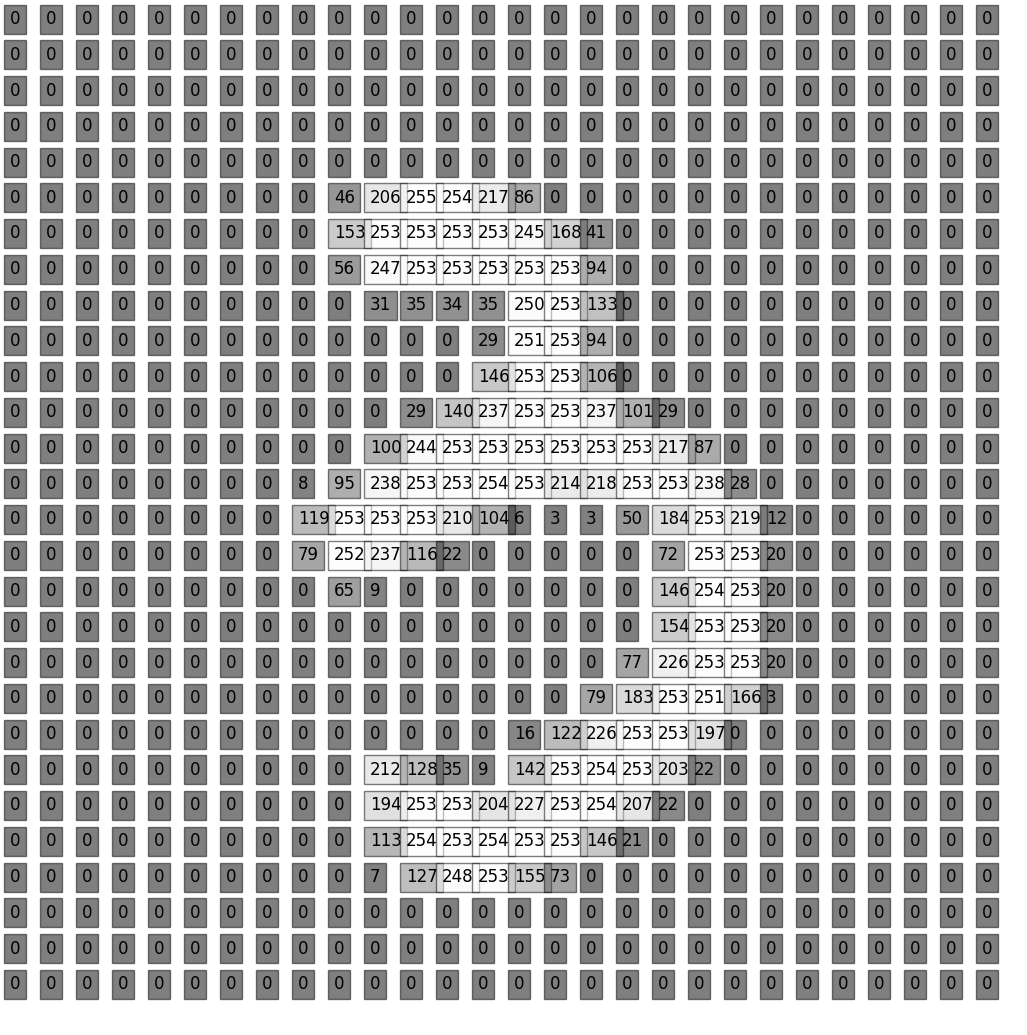

In [13]:
rand_number = random.randint(0, len(y_train))
print(y_train[rand_number])
plot_digit(x_train_plot[rand_number])

Total number of digits in dataset

Index([1, 7, 3, 9, 2, 6, 0, 4, 8, 5], dtype='int64', name='label')
[4684 4401 4351 4188 4177 4137 4132 4072 4063 3795]


<BarContainer object of 10 artists>

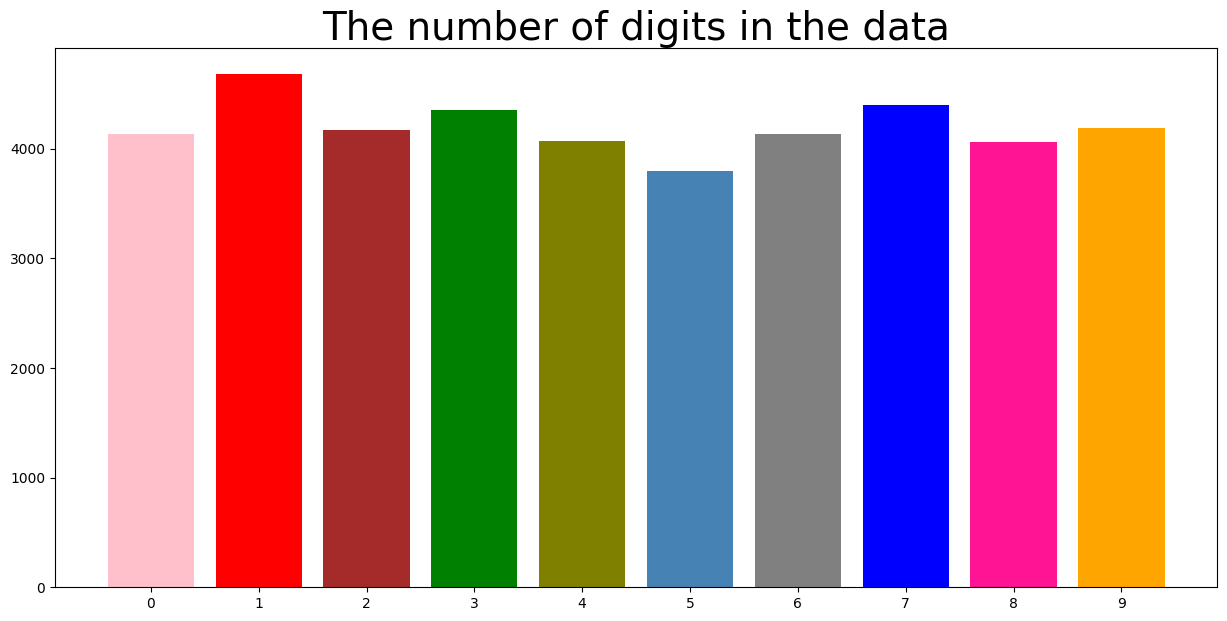

In [14]:
digit_range = np.arange(10)

val = y_train.value_counts().index
print(val)
cnt = y_train.value_counts().values
print(cnt)
mycolors=["red","blue","green","orange",'brown',"grey","pink","olive","deeppink","steelblue"]

plt.figure(figsize=(15,7))
plt.title("The number of digits in the data",fontsize=28)
plt.xticks(range(10))
plt.bar(val,cnt,color=mycolors)

In [15]:
img_rows ,img_cols = 28,28

num_pixels = x_train.shape[1]
print(num_pixels)
input_shape = (img_rows,img_cols)

784


In [16]:
# Data Normalization [0,1]
x_train /= 255  # eg. 220 / 255 ≈ 0.8627
x_test /= 255

# one-hot encoding
y_train = to_categorical(y_train)

num_classes = y_train.shape[1]

print(x_train.shape,x_test.shape)

(42000, 784) (28000, 784)


Split Data ( k-fold technique)

In [17]:
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size=0.1,random_state=7,stratify=y_train) # stratify=y_train ensures balanced class distribution

# Model 1 : MLP(MultiLayer Perceptor)

- input Layer - 28*28 pixel reshape to vector
- hidden Layer
- output Layer has 10 neuron

In [18]:
# f1-score function
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [79]:
import matplotlib.pyplot as plt

def accuracy_graph(model_name, accuracy, error):
    """
    Generates and saves a clean accuracy vs error bar graph for any model.

    Parameters:
    - model_name (str): Name used for saving the output image.
    - accuracy (float): Accuracy percentage (0–100).
    - error (float): Error percentage (0–100).
    """

    plt.figure(figsize=(7, 5))

    # Draw bars
    bars = plt.bar(["Accuracy", "Error"], [accuracy, error])

    # Remove top & right borders for modern style
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Title with spacing
    plt.title(f"{model_name} HandWritten-text classifier Performance", fontsize=14, pad=20)

    # Y-label
    plt.ylabel("Percentage (%)", fontsize=12, labelpad=10)
    plt.ylim(0, 110)

    # Cleaner tick style
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=10)

    # Add value labels above bars
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height + 3,
            f"{height:.2f}%",
            ha='center',
            fontsize=11,
            fontweight='bold'
        )

    # Add padding around plot
    plt.subplots_adjust(left=0.12, right=0.95, top=0.9, bottom=0.12)

    # Save high-quality image
    safe_name = model_name.replace(" ", "_")  # safe filename
    plt.savefig(f"{safe_name}_accuracy.png", dpi=300, bbox_inches="tight")

    plt.show()


In [ ]:
def draw_learning_curve(history, keys=['f1', 'loss']):
    plt.figure(figsize=(20,8))
    for i, key in enumerate(keys):
        plt.subplot(1, 2, i + 1)
        sns.lineplot(x = history.epoch, y = history.history[key])
        sns.lineplot(x = history.epoch, y = history.history['val_' + key])
        plt.title('Learning Curve')
        plt.ylabel(key.title())
        plt.xlabel('Epoch')
#         plt.ylim(ylim)
        plt.legend(['train', 'test'], loc='best')
        plt.savefig("model_learning_curve.png", dpi=300)
    plt.show()

In [20]:
def callbacks(name):
    return [
        EarlyStopping(monitor='loss', patience=6),
        ReduceLROnPlateau(monitor='loss', patience=3),
        ModelCheckpoint(f'../working/{name}.keras', save_best_only=True)  # <-- corrected here
    ]


In [21]:
def get_mlp():
    return Sequential([
        #input layer auto generate by keras
        #hidden Layer:
        Dense(512,input_dim=num_pixels,activation="relu"),
        #output Layer
        Dense(num_classes,activation="softmax") # 10 neuron in output layer
    ])

In [22]:
model = get_mlp()
model.compile(loss="categorical_crossentropy",optimizer='adam',metrics=[f1])
model.summary()

e:\PYTHON\adv projects\handwritten_text_classifier\Venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 407,050 (1.55 MB)

 Trainable params: 407,050 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
print(f'Network has {model.count_params()} params (weights)')


Network has 407050 params (weights)


In [24]:
learning_history = model.fit(
    x_train,y_train,
    batch_size=1024,
    epochs=40,
    verbose=2,
    callbacks=callbacks('simple_mlp'),
    validation_data=(x_val,y_val))

Epoch 1/40
37/37 - 1s - 32ms/step - f1: 0.7031 - loss: 0.7070 - val_f1: 0.9186 - val_loss: 0.3146 - learning_rate: 0.0010
Epoch 2/40
37/37 - 0s - 11ms/step - f1: 0.9235 - loss: 0.2723 - val_f1: 0.9350 - val_loss: 0.2415 - learning_rate: 0.0010
Epoch 3/40
37/37 - 0s - 11ms/step - f1: 0.9409 - loss: 0.2105 - val_f1: 0.9471 - val_loss: 0.1945 - learning_rate: 0.0010
Epoch 4/40
37/37 - 0s - 11ms/step - f1: 0.9517 - loss: 0.1736 - val_f1: 0.9552 - val_loss: 0.1703 - learning_rate: 0.0010
Epoch 5/40
37/37 - 1s - 15ms/step - f1: 0.9602 - loss: 0.1453 - val_f1: 0.9603 - val_loss: 0.1517 - learning_rate: 0.0010
Epoch 6/40
37/37 - 0s - 11ms/step - f1: 0.9664 - loss: 0.1232 - val_f1: 0.9645 - val_loss: 0.1383 - learning_rate: 0.0010
Epoch 7/40
37/37 - 0s - 11ms/step - f1: 0.9714 - loss: 0.1065 - val_f1: 0.9656 - val_loss: 0.1282 - learning_rate: 0.0010
Epoch 8/40
37/37 - 0s - 13ms/step - f1: 0.9748 - loss: 0.0936 - val_f1: 0.9669 - val_loss: 0.1211 - learning_rate: 0.0010
Epoch 9/40
37/37 - 0s - 

In [25]:
score = model.evaluate(x_val,y_val,verbose=0)
print('Test loss: {}%'.format(score[0] * 100))
print('Test score: {}%'.format(score[1] * 100))

print("MLP Error: %.2f%%" % (100 - score[1] * 100))

Test loss: 8.872255682945251%
Test score: 97.60096073150635%
MLP Error: 2.40%


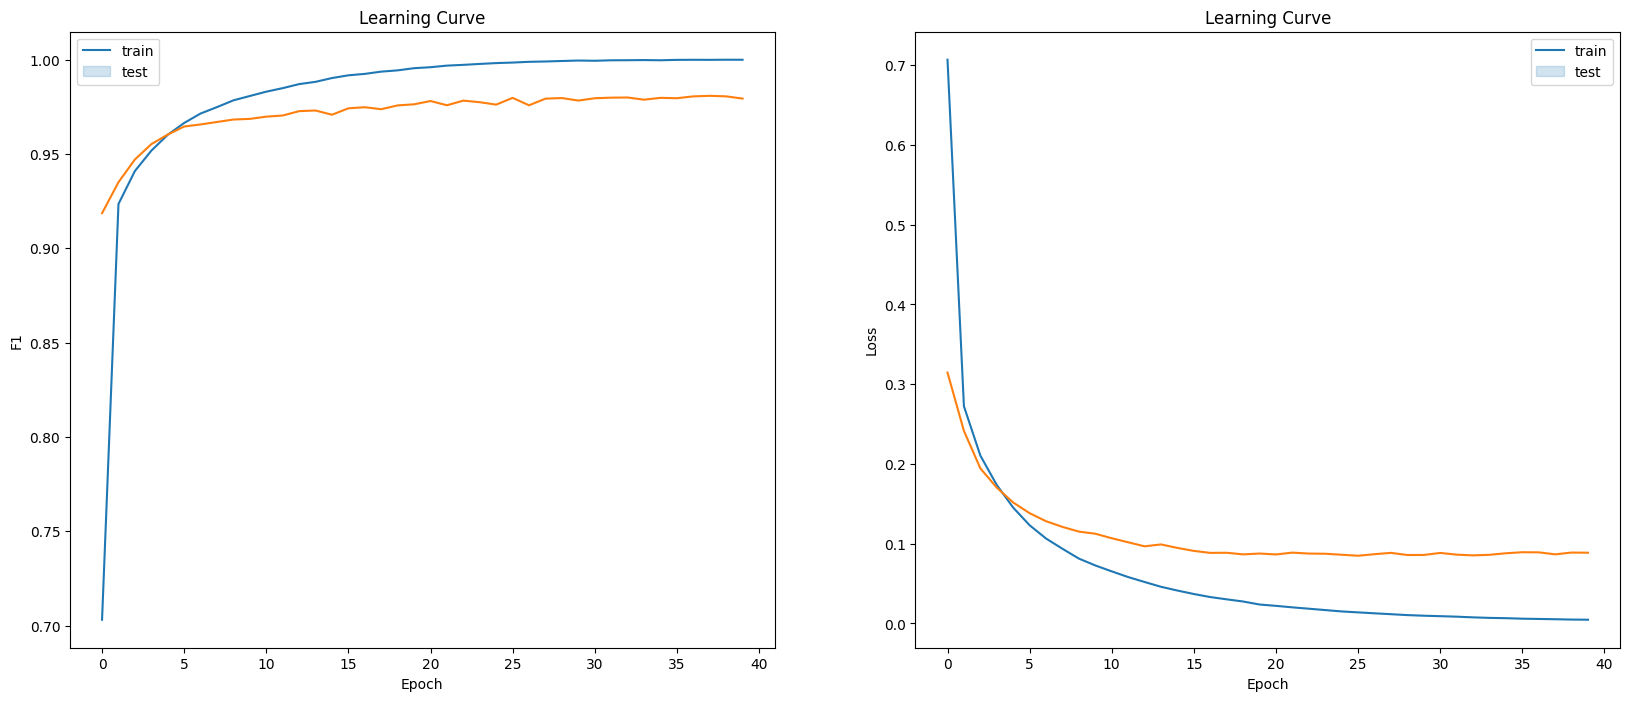

In [26]:
draw_learning_curve(learning_history)

 **cool! got 97.54% accuracy :)**

In [27]:
#Letsadd new layers and dropout to avoid overfitting
def get_mlpv2():
    return Sequential([
        Dense(512, input_dim=num_pixels, activation='relu'),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

In [44]:
mlp_model = get_mlpv2()
mlp_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1])
mlp_model.summary()

e:\PYTHON\adv projects\handwritten_text_classifier\Venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 567,434 (2.16 MB)

 Trainable params: 567,434 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
learning_history = mlp_model.fit(x_train, y_train,
          batch_size = 1024, epochs = 40, verbose = 2, callbacks = callbacks('mlp_reg'),
          validation_data=(x_val, y_val));

Epoch 1/40


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(None, 28, 28, 1), dtype=float32). Expected shape (None, 784), but input has incompatible shape (None, 28, 28, 1)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 28, 28, 1), dtype=float32)
  • training=True
  • mask=None
  • kwargs=<class 'inspect._empty'>

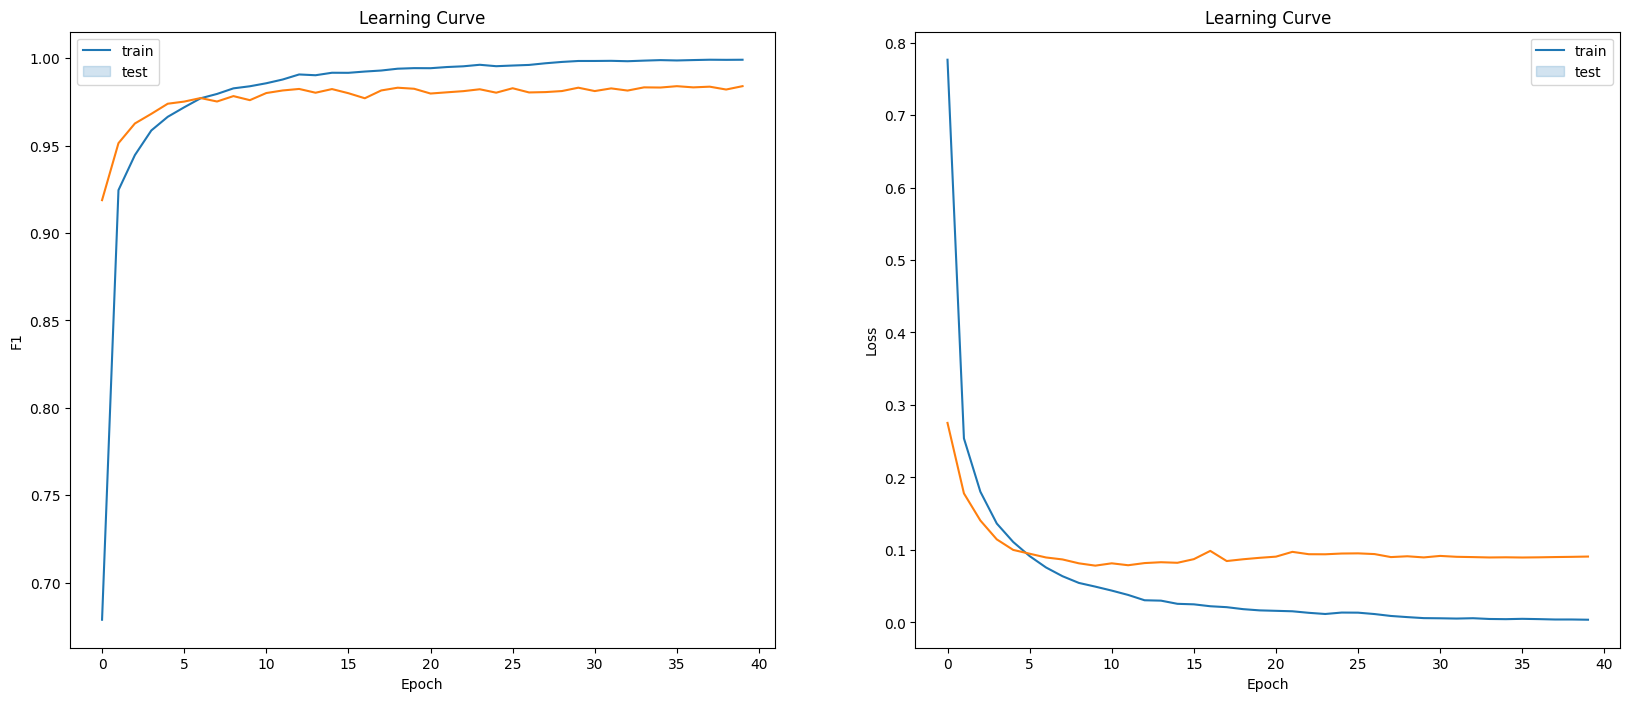

In [ ]:
draw_learning_curve(learning_history)

In [81]:
score = mlp_model.evaluate(x_val, y_val, verbose = 0)
print('Test loss: {}%'.format(score[0] * 100))
print('Test score: {}%'.format(score[1] * 100))

print("MLP Error: %.2f%%" % (100 - score[1] * 100))

ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(None, 28, 28, 1), dtype=float32). Expected shape (None, 784), but input has incompatible shape (None, 28, 28, 1)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 28, 28, 1), dtype=float32)
  • training=False
  • mask=None
  • kwargs=<class 'inspect._empty'>

In [69]:
version = "v1"
model_name = "mlp"
filename = f"{model_name}_{version}.keras"
mlp_model.save(f"handwritten_text_classifier/{filename}")


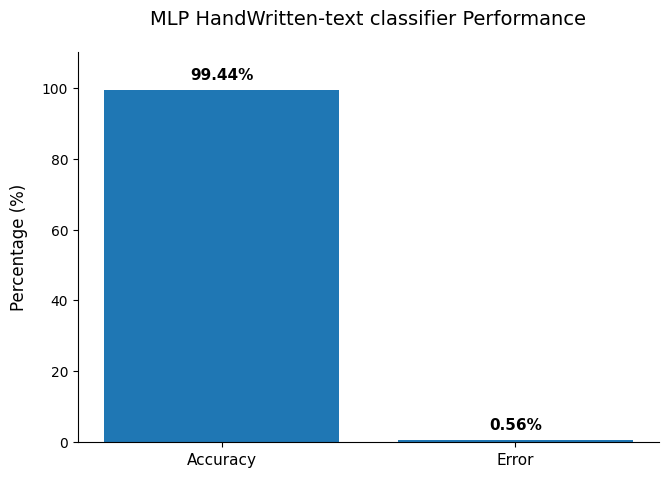

In [80]:
mlp_accuracy = score[1] * 100
mlp_error = 100 - mlp_accuracy

accuracy_graph("MLP", mlp_accuracy, mlp_error)


# MODEL 2 : CNN(Convulation Neural Network)

CNN have :
  - convulation Layer :
      - filters
      - kernel size
  - pooling Layer
  - Flatten Layer
  - Dense Layer
  - Ouput Layer

In [37]:
x_train.shape

(37800, 784)

In [41]:
x_train = x_train.values.reshape(-1, 28, 28, 1)
x_val = x_val.values.reshape(-1, 28, 28, 1)
x_test = x_test.values.reshape(-1, 28, 28, 1)
input_shape = (28, 28, 1)


In [35]:
def get_cnn():
    return Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape = input_shape),
        Conv2D(32, kernel_size=(3, 3), activation='relu' ),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu' ),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(128,kernel_size=(3,3),activation="relu",padding='same'),

        Conv2D(128,kernel_size=(3,3),activation="relu"),
        MaxPool2D(pool_size=(2,2)),
        Dropout(0.25),

        Flatten(),

        Dense(256,activation="relu"),
        Dropout(0.5),
        Dense(num_classes,activation="softmax")
        
    ])

In [42]:
model = get_cnn()
model.compile(loss="categorical_crossentropy",optimizer='adam',metrics=[f1])
model.summary()

e:\PYTHON\adv projects\handwritten_text_classifier\Venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 26, 26, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 11, 11, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 5, 5, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 3, 3, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 322,026 (1.23 MB)

 Trainable params: 322,026 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
learning_history = model.fit(
    x_train,y_train,
    batch_size=128,
    epochs=50,
    verbose=1,
    callbacks=callbacks('cnn_v1'),
    validation_data=(x_val,y_val))

Epoch 1/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 18s 53ms/step - f1: 0.8055 - loss: 0.5168 - val_f1: 0.9769 - val_loss: 0.0804 - learning_rate: 0.0010
Epoch 2/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 16s 53ms/step - f1: 0.9706 - loss: 0.1039 - val_f1: 0.9856 - val_loss: 0.0502 - learning_rate: 0.0010
Epoch 3/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - f1: 0.9789 - loss: 0.0748 - val_f1: 0.9894 - val_loss: 0.0417 - learning_rate: 0.0010
Epoch 4/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - f1: 0.9834 - loss: 0.0555 - val_f1: 0.9895 - val_loss: 0.0434 - learning_rate: 0.0010
Epoch 5/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 18s 62ms/step - f1: 0.9851 - loss: 0.0516 - val_f1: 0.9890 - val_loss: 0.0354 - learning_rate: 0.0010
Epoch 6/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - f1: 0.9878 - loss: 0.0427 - val_f1: 0.9895 - val_loss: 0.0361 - learning_rate: 0.0010
Epoch 7/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - f1: 0.9887 - loss: 0.0403 - val_f1: 0.9902 - val_loss: 0.0357 - learning_rate: 0.0010
Epoch 

In [46]:
score = model.evaluate(x_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test score:', score[1])

print("CNN Error: %.2f%%" % (100-score[1]*100))

Test loss: 0.03495011106133461
Test score: 0.9944308996200562
CNN Error: 0.56%


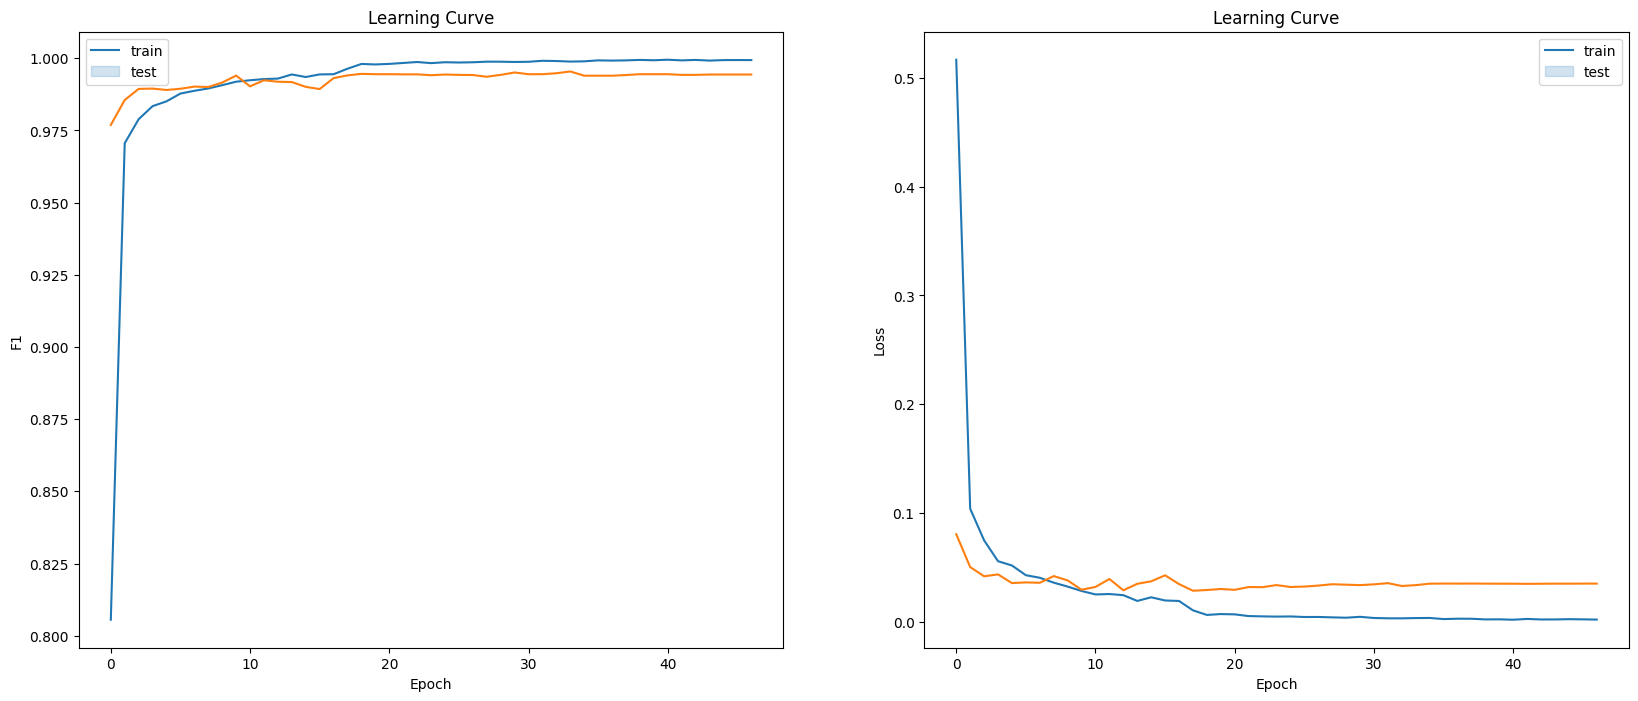

In [47]:
draw_learning_curve(learning_history)

In [49]:
version = "v1"
model_name = "cnn"
filename = f"{model_name}_{version}.keras"
model.save(f"handwritten_text_classifier/{filename}")

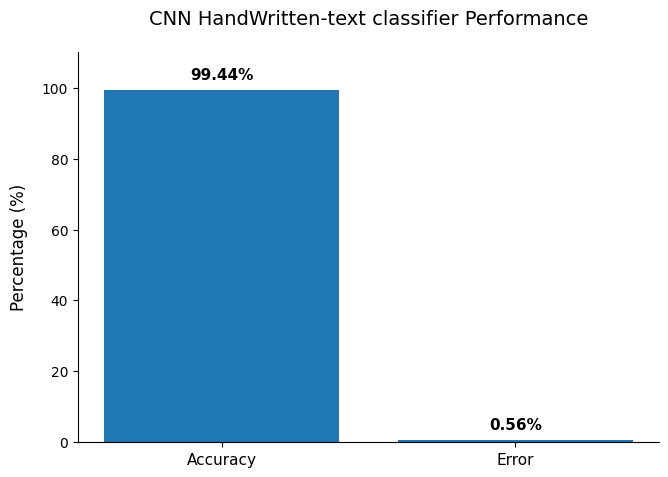

In [78]:
cnn_accuracy = score[1] * 100
cnn_error = 100 - cnn_accuracy

accuracy_graph("CNN", cnn_accuracy, cnn_error)
